In [1]:
import sys
!{sys.executable} -m pip install datasets


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: /usr/local/bin/python3.9 -m pip install --upgrade pip


In [2]:
!pip install --upgrade transformers

zsh:1: command not found: pip


In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
from datasets import load_dataset

dataset = load_dataset("casehold/casehold")


In [5]:
# Access each split
train_data = dataset["train"].select(range(3000))
val_data = dataset["validation"].select(range(500))
test_data = dataset["test"].select(range(500))

In [6]:
print(f'Train size: {len(train_data)}')
print(f'Validation size: {len(val_data)}')
print(f'Test size: {len(test_data)}')

Train size: 3000
Validation size: 500
Test size: 500


In [7]:
import pandas as pd

df_train = pd.DataFrame(train_data)
df_val = pd.DataFrame(val_data)
df_test = pd.DataFrame(test_data)

df_train.drop(columns=['example_id'], inplace=True)
df_val.drop(columns=['example_id'], inplace=True)
df_test.drop(columns=['example_id'], inplace=True)

df_train['label'] = df_train['label'].astype(int)
df_val['label'] = df_val['label'].astype(int)
df_test['label'] = df_test['label'].astype(int)

print(df_train.head())

                                       citing_prompt  \
0  Drapeau’s cohorts, the cohort would be a “vict...   
1  Colameta used customer information that he too...   
2  property tax sale. In reviewing section 6323(b...   
3  They also rely on Oswego Laborers’ Local 214 P...   
4  did not affect the defendant’s guideline range...   

                                           holding_0  \
0  holding that possession of a pipe bomb is a cr...   
1  recognizing that even if a plaintiff claims ce...   
2  holding that where there is a conflict between...   
3  holding that plaintiff stated a  349 claim whe...   
4  holding that united states v booker 543 us 220...   

                                           holding_1  \
0  holding that bank robbery by force and violenc...   
1  holding that included among trade secrets empl...   
2  holding that specific statutory provisions tak...   
3  holding that plaintiff stated a claim for brea...   
4  holding that waiver of right to appeal sent

In [8]:
columns = df_train.columns.tolist()
print(columns)

['citing_prompt', 'holding_0', 'holding_1', 'holding_2', 'holding_3', 'holding_4', 'label']


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import re

# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text.strip()

# Build vocabulary
def build_vocab(texts, max_vocab_size=20000):
    counter = Counter()
    for text in texts:
        counter.update(clean_text(text).split())
    vocab = ['<PAD>', '<UNK>'] + [word for word, _ in counter.most_common(max_vocab_size-2)]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    return word2idx

# Tokenize
def encode(text, word2idx, max_len=64):
    tokens = clean_text(text).split()
    ids = [word2idx.get(token, word2idx['<UNK>']) for token in tokens][:max_len]
    ids += [word2idx['<PAD>']] * (max_len - len(ids))
    return ids

In [10]:
# Custom dataset
class CaseHOLD_Dataset(Dataset):
    def __init__(self, dataframe, word2idx, max_len=64):
        self.data = dataframe
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        prompt = encode(row['citing_prompt'], self.word2idx, self.max_len)
        holdings = [encode(row[f'holding_{i}'], self.word2idx, self.max_len) for i in range(5)]
        label = int(row['label'])
        return torch.tensor(prompt), torch.stack([torch.tensor(h) for h in holdings]), torch.tensor(label)

In [11]:
# Model
class CaseHOLD_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256):
        super(CaseHOLD_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_dim * 2, 1)

    def encode(self, x):
        emb = self.embedding(x)
        _, (hn, _) = self.encoder(emb)
        return torch.cat((hn[-2], hn[-1]), dim=1)

    def forward(self, prompt, holdings):
        prompt_vec = self.encode(prompt)
        holding_vecs = [self.encode(holdings[:, i, :]) for i in range(5)]
        holding_vecs = torch.stack(holding_vecs, dim=1)  # (B, 5, H)
        prompt_vec = prompt_vec.unsqueeze(1).repeat(1, 5, 1)  # (B, 5, H)
        logits = self.classifier(torch.tanh(prompt_vec * holding_vecs)).squeeze(-1)
        return logits

In [12]:
# Combine all citing_prompts and holdings
all_texts = []

# Add cleaned citing_prompts and holdings to list
for df in [df_train, df_val, df_test]:
    for col in ['citing_prompt'] + [f'holding_{i}' for i in range(5)]:
        # Convert to string and replace NaN or float with ''
        df[col] = df[col].fillna('').astype(str)
        all_texts.extend(df[col].tolist())

# Final cleanup: make sure all entries are strings
all_texts = [str(text) if isinstance(text, str) else "" for text in all_texts]

# Now build the vocabulary
word2idx = build_vocab(all_texts)

In [13]:
train_dataset = CaseHOLD_Dataset(df_train, word2idx)
val_dataset = CaseHOLD_Dataset(df_val, word2idx)
test_dataset = CaseHOLD_Dataset(df_test, word2idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=1)

In [14]:
len(word2idx)

20000

In [ ]:
model = CaseHOLD_Model(len(word2idx)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# def train(model, dataloader, criterion, optimizer, device):
#     model.train()
#     total_loss = 0
#     correct = 0
#     total = 0

#     for prompt, holdings, label in dataloader:
#         prompt = prompt.to(device)
#         holdings = holdings.to(device)
#         label = label.to(device)

#         optimizer.zero_grad()
#         logits = model(prompt, holdings)
#         loss = criterion(logits, label)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         preds = torch.argmax(logits, dim=1)
#         correct += (preds == label).sum().item()
#         total += label.size(0)

#     avg_loss = total_loss / len(dataloader)
#     accuracy = correct / total
#     print(f"Train Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
#     return avg_loss, accuracy


# def evaluate(model, dataloader, criterion, device):
#     model.eval()
#     total_loss = 0
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for prompt, holdings, label in dataloader:
#             prompt = prompt.to(device)
#             holdings = holdings.to(device)
#             label = label.to(device)

#             logits = model(prompt, holdings)
#             loss = criterion(logits, label)

#             total_loss += loss.item()
#             preds = torch.argmax(logits, dim=1)
#             correct += (preds == label).sum().item()
#             total += label.size(0)

#     avg_loss = total_loss / len(dataloader)
#     accuracy = correct / total
#     print(f"Val Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
#     return avg_loss, accuracy

In [ ]:
# updated
import os
import torch
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for prompt, holdings, label in dataloader:
            prompt, holdings, label = prompt.to(device), holdings.to(device), label.to(device)
            logits = model(prompt, holdings)
            loss = criterion(logits, label)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == label).sum().item()
            total += label.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    print(f"Val Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy

In [ ]:
def train(model, dataloader, criterion, optimizer, device, val_loader, num_epochs=3, save_path="best_casehold_model.pt"):
    best_val_acc = 0.0

    # Load existing checkpoint if available
    if os.path.exists(save_path):
        checkpoint = torch.load(save_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_val_acc = checkpoint['val_accuracy']
        print(f"Loaded existing model from {save_path} with val accuracy: {best_val_acc:.4f}")

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for prompt, holdings, label in dataloader:

            prompt, holdings, label = prompt.to(device), holdings.to(device), label.to(device)
            logits = model(prompt, holdings)
            loss = criterion(logits, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == label).sum().item()
            total += label.size(0)

        avg_train_loss = total_loss / len(dataloader)
        train_acc = correct / total

        # Evaluate on validation set
        avg_val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # Save metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch:2d} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': best_val_acc
            }, save_path)
            print(f"New best model saved at {save_path} with val accuracy: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# num_epochs = 10

# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []

# for epoch in range(num_epochs):
#     print(f"\nEpoch {epoch+1}/{num_epochs}")
#     # train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
#     # val_loss, val_acc = evaluate(model, val_loader, criterion, device)

# train_losses.append(train_loss)
# val_losses.append(val_loss)
# train_accuracies.append(train_acc)
# val_accuracies.append(val_acc)

In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, criterion, optimizer, device, val_loader, num_epochs=10, save_path="best_casehold_model.pt")

Loaded existing model from best_casehold_model.pt with val accuracy: 0.3360
Val Loss: 1.6001, Accuracy: 0.2540
Epoch  1 | Train Loss: 1.5521 | Train Acc: 0.3227 | Val Acc: 0.2540
Val Loss: 1.6318, Accuracy: 0.2840
Epoch  2 | Train Loss: 1.4098 | Train Acc: 0.4090 | Val Acc: 0.2840
Val Loss: 1.6683, Accuracy: 0.3020
Epoch  3 | Train Loss: 1.2611 | Train Acc: 0.4977 | Val Acc: 0.3020
Val Loss: 1.7750, Accuracy: 0.2860
Epoch  4 | Train Loss: 1.0730 | Train Acc: 0.5857 | Val Acc: 0.2860
Val Loss: 1.8454, Accuracy: 0.2980
Epoch  5 | Train Loss: 0.8327 | Train Acc: 0.6873 | Val Acc: 0.2980
Val Loss: 2.3735, Accuracy: 0.3040
Epoch  6 | Train Loss: 0.5926 | Train Acc: 0.7927 | Val Acc: 0.3040
Val Loss: 2.7466, Accuracy: 0.3020
Epoch  7 | Train Loss: 0.3765 | Train Acc: 0.8713 | Val Acc: 0.3020
Val Loss: 3.1877, Accuracy: 0.3000
Epoch  8 | Train Loss: 0.2454 | Train Acc: 0.9237 | Val Acc: 0.3000
Val Loss: 3.5599, Accuracy: 0.3080
Epoch  9 | Train Loss: 0.1670 | Train Acc: 0.9493 | Val Acc: 0.30

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Loss Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

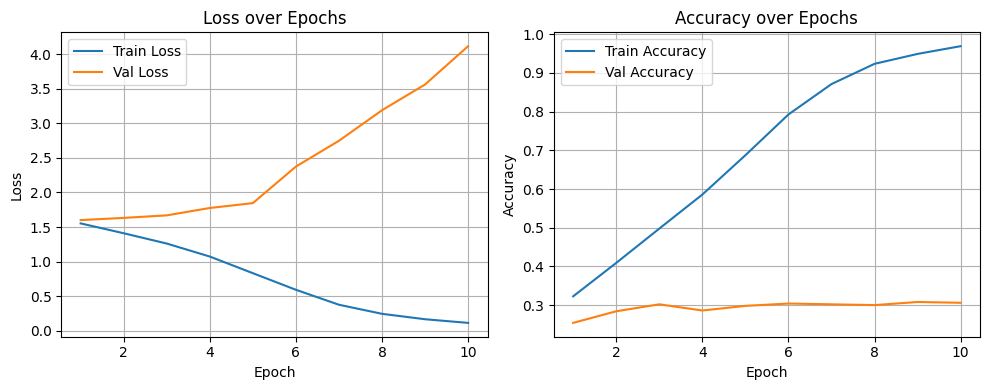

In [ ]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np

def evaluate_on_test(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for prompt, holdings, label in test_loader:
            prompt = prompt.to(device)
            holdings = holdings.to(device)
            label = label.to(device)

            logits = model(prompt, holdings)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Accuracy
    accuracy = np.mean(all_preds == all_labels)
    print(f"Test Accuracy: {accuracy:.4f}")

    # F1-Score (macro and micro)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    print(f"F1 Macro: {f1_macro:.4f} | F1 Micro: {f1_micro:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Per-class Accuracy
    print("\nPer-class Accuracy:")
    class_acc = cm.diagonal() / cm.sum(axis=1)
    for i, acc in enumerate(class_acc):
        name = class_names[i] if class_names else f"Holding {i}"
        print(f"{name}: {acc:.4f}")

    # Classification Report
    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names if class_names else [f"Holding {i}" for i in range(5)]))

In [ ]:
evaluate_on_test(model, test_loader, device)

Test Accuracy: 0.2820
F1 Macro: 0.2819 | F1 Micro: 0.2820

Confusion Matrix:
[[24  9 15 15 14]
 [16 29 23 21 14]
 [24 22 29 17 19]
 [12 18 22 26 13]
 [19 18 18 30 33]]

Per-class Accuracy:
Holding 0: 0.3117
Holding 1: 0.2816
Holding 2: 0.2613
Holding 3: 0.2857
Holding 4: 0.2797

Detailed Classification Report:
              precision    recall  f1-score   support

   Holding 0       0.25      0.31      0.28        77
   Holding 1       0.30      0.28      0.29       103
   Holding 2       0.27      0.26      0.27       111
   Holding 3       0.24      0.29      0.26        91
   Holding 4       0.35      0.28      0.31       118

    accuracy                           0.28       500
   macro avg       0.28      0.28      0.28       500
weighted avg       0.29      0.28      0.28       500

